In [1]:
import os
import sys
import time
from datetime import datetime
import pickle
import json

import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import sem
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.datasets import mnist, fashion_mnist # type: ignore
import cv2
from cv2 import GaussianBlur
from sklearn.feature_extraction.image import extract_patches_2d
from skimage.metrics import structural_similarity as ssi


# D-Wave
from dwave.samplers import SimulatedAnnealingSampler
from dwave.system import LeapHybridSampler, LeapHybridCQMSampler
from dimod import CQM, Binary, Integer, quicksum

# Import environment variables
import dotenv
dotenv.load_dotenv()
solver_token = os.getenv('SOLVER_TOKEN')

# Import utilities
from utils_binary import *



29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Original shape: (60000, 28, 28)
Downsized shape: (60000, 28, 28)
(60000, 28, 28) uint8
(10000, 28, 28) uint8


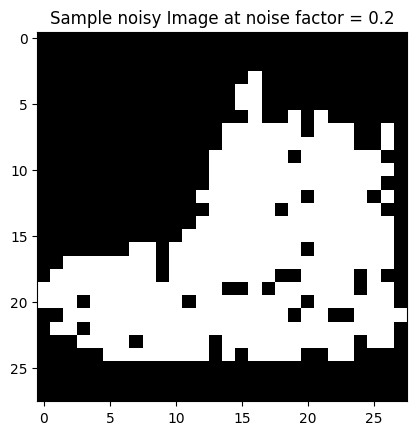

In [12]:
# Prepare MNIST Data 

# Load and preprocess the MNIST dataset
np.random.seed(0)
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(f'Original shape: {x_train.shape}')
image_shape = (28,28)
x_train = np.array(tf.image.resize(x_train[..., tf.newaxis], image_shape, method=tf.image.ResizeMethod.BILINEAR))
x_test = np.array(tf.image.resize(x_test[..., tf.newaxis], image_shape, method=tf.image.ResizeMethod.BILINEAR))
x_train = x_train.reshape((len(x_train), 28, 28))
x_test = x_test.reshape((len(x_test), 28, 28))
print(f'Downsized shape: {x_train.shape}')

# Scale between [0,1] and set dtype
x_train = x_train / 255
x_test  = x_test  / 255

# Add Gaussian noise to the images
noise_factor = 0.2 # @param
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy  = x_test  + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the pixel values to the valid range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy  = np.clip(x_test_noisy,  0., 1.)

# # Reshape data for the model
# x_train_noisy = np.reshape(x_train_noisy, (len(x_train_noisy), 12, 12, 1))
# x_test_noisy = np.reshape(x_test_noisy, (len(x_test_noisy), 12, 12, 1))

# # Rescale to [0, 255]
# x_train = x_train * 255
# x_test  = x_test  * 255

# # # Set dtype
# x_train = x_train.astype('float32')
# x_test  = x_test.astype('float32')
# x_train_noisy = x_train_noisy.astype('float32')
# x_test_noisy  = x_test_noisy.astype('float32')

# Binarize the images

threshold = 0.5

x_train_binary = (x_train > threshold).astype(np.uint8)
x_test_binary = (x_test > threshold).astype(np.uint8)
x_train_noisy_binary = (x_train_noisy > threshold).astype(np.uint8)
x_test_noisy_binary = (x_test_noisy > threshold).astype(np.uint8)

# Verify the shapes
print(x_train_binary.shape, x_train_binary.dtype)
print(x_test_binary.shape, x_test_binary.dtype)

if True:
  plt.imshow(x_train_noisy_binary[0], cmap='gray')
  plt.title(f'Sample noisy Image at noise factor = {noise_factor}')
  plt.show()


# Simple Example

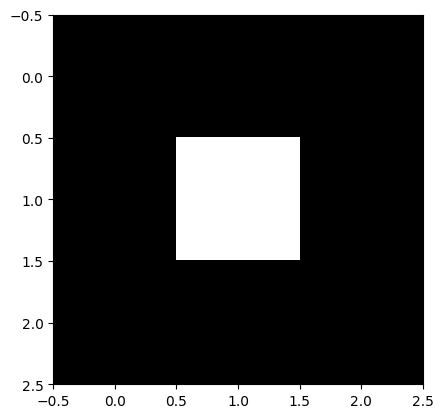

array([[0, 0, 0],
       [0, 1, 0],
       [0, 0, 0]], dtype=int8)

In [2]:
# X_noisy = np.array([[0, 0, 0, 0, 0, 0],
#                     [0, 0, 0, 0, 0, 0],
#                     [0, 0, 1, 1, 1, 0],
#                     [0, 0, 1, 0, 1, 0],
#                     [0, 0, 1, 1, 1, 0],
#                     [0, 0, 0, 0, 0, 0]])

X_noisy = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

run_qubo(X_noisy, l=0.9, simulate=True, show_solution=True)

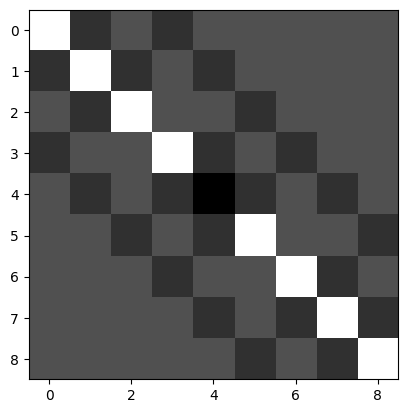

In [ ]:
show_image(get_Q(X_noisy, l=0.9))

In [ ]:
# @title
print('Initial')
Q = get_Q(X_noisy, l=0.5, order=1)
show_energy(X_noisy, X_noisy, order=1)
for l in [0.7, 0.8, 0.9]:
  Q = get_Q(X_noisy, l=l)
  sampler = SimulatedAnnealingSampler()
  sampleset = sample_qubo(Q, sampler, label='RMF')
  solution = np.array(list(sampleset.first[0].values())).reshape(X_noisy.shape)

  print()
  print(f'l = {l}')
  show_energy(solution, X_noisy, order=1)
  print()

Initial
Energy Neighbors: 0.0
Energy Retention: -8.0
Energy Total: -8.0000

l = 0.7
Energy Neighbors: -136.0
Energy Retention: 156.0
Energy Total: 20.0000


l = 0.8
Energy Neighbors: -136.0
Energy Retention: 156.0
Energy Total: 20.0000


l = 0.9
Energy Neighbors: -12.0
Energy Retention: 5.0
Energy Total: -7.0000



In [ ]:
# @title
# X_noisy = np.array([[0, 0, 0, 0, 0, 0],
#                     [0, 0, 1, 1, 1, 0],
#                     [0, 0, 1, 0, 1, 0],
#                     [0, 0, 1, 1, 1, 0],
#                     [0, 0, 0, 0, 0, 0],
#                     [0, 0, 0, 0, 0, 0]])

X_noisy = np.array([[1, 1, 0, 0, 0, 1],
                    [1, 1, 0, 0, 0, 1],
                    [1, 1, 0, 0, 0, 1],
                    [1, 1, 0, 0, 0, 1],
                    [1, 1, 0, 0, 0, 1],
                    [1, 1, 0, 1, 0, 1]])

print('Initial')
order = 1
Q = get_Q(X_noisy, l=0.5, order=order)
show_energy(X_noisy, X_noisy, order=order)

ls = [0.3, 0.7, 0.8, 0.9]
# ls = [0.84, 0.845, 0.85]
for l in ls:
  Q = get_Q(X_noisy, l=l)
  sampler = SimulatedAnnealingSampler()
  sampleset = sample_qubo(Q, sampler, label='RMF')
  solution = np.array(list(sampleset.first[0].values())).reshape(X_noisy.shape)
  # plt.imshow(solution, cmap='gray')
  # plt.title(f'l = {l}')
  # plt.colorbar()
  # plt.show()


  print()
  print(f'l = {l}')
  show_energy(solution, X_noisy, order=order)
  print(solution)
  print()

Initial
Energy Neighbors: -38.0
Energy Retention: 19.0
Energy Total: -19.0000

l = 0.3
Energy Neighbors: -136.0
Energy Retention: 134.0
Energy Total: -2.0000
[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]]


l = 0.7
Energy Neighbors: -136.0
Energy Retention: 134.0
Energy Total: -2.0000
[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]]


l = 0.8
Energy Neighbors: -136.0
Energy Retention: 134.0
Energy Total: -2.0000
[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]]


l = 0.9
Energy Neighbors: -38.0
Energy Retention: 19.0
Energy Total: -19.0000
[[1 1 0 0 0 1]
 [1 1 0 0 0 1]
 [1 1 0 0 0 1]
 [1 1 0 0 0 1]
 [1 1 0 0 0 1]
 [1 1 0 1 0 1]]



### Some viz


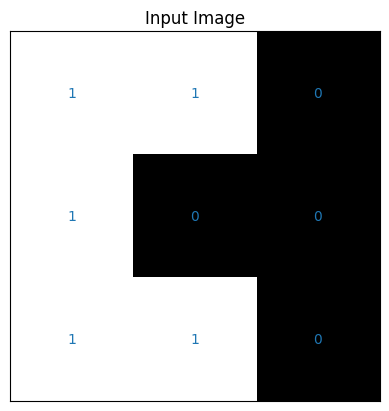

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Your image matrix
X_noisy = np.array([
    [1, 1, 0],
    [1, 0, 0],
    [1, 1, 0]
])
# X_noisy = np.array([
#     [0, 1],
#     [0, 1],
# ])

# Plotting the matrix
fig, ax = plt.subplots()
cax = ax.imshow(X_noisy, cmap='gray', interpolation='nearest')

# Adding gridlines to create a border effect
ax.set_xticks(np.arange(-0.5, X_noisy.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, X_noisy.shape[0], 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)

# Turn off the major ticks
ax.tick_params(which='major', bottom=False, left=False, labelbottom=False, labelleft=False)

# Adding pixel intensity values
for i in range(X_noisy.shape[0]):
    for j in range(X_noisy.shape[1]):
        ax.text(j, i, f'{X_noisy[i, j]}', ha='center', va='center', color='C0')

# plt.xlabel(r'$j$')
# plt.ylabel(r'$i$')


plt.title('Input Image')
plt.show()


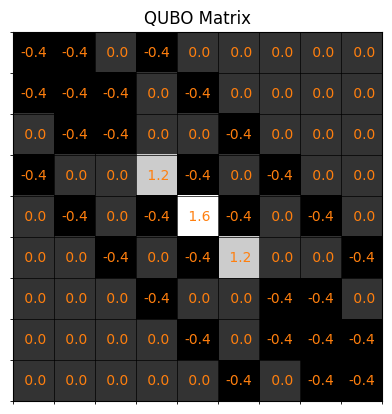

In [ ]:

Q = get_Q(X_noisy)

# Plotting the matrix
fig, ax = plt.subplots()
cax = ax.imshow(Q, cmap='gray', interpolation='nearest')

# Adding gridlines to create a border effect
ax.set_xticks(np.arange(-0.5, Q.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, Q.shape[0], 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

# Turn off the major ticks
ax.tick_params(which='major', bottom=False, left=False, labelbottom=False, labelleft=False)

# Adding pixel intensity values
for i in range(Q.shape[0]):
    for j in range(Q.shape[1]):
        ax.text(j, i, f'{Q[i, j] : 0.1f}', ha='center', va='center', color='C1')

plt.title('QUBO Matrix')
plt.show()


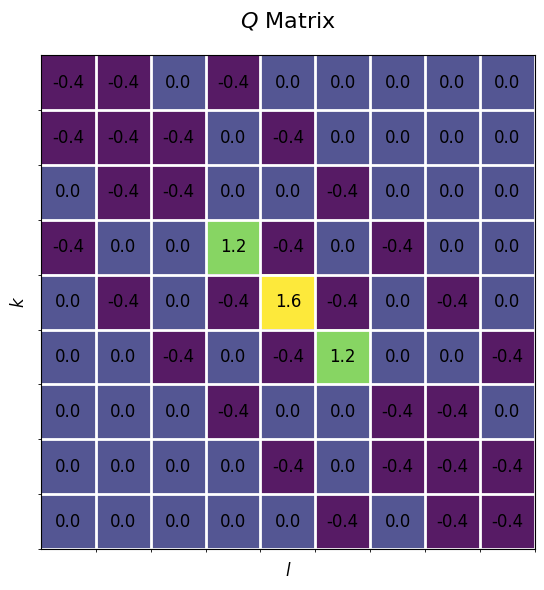

In [ ]:


# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the matrix using imshow with a vibrant colormap
cax = ax.imshow(Q, cmap='viridis', interpolation='nearest', alpha=0.9)

# Customize gridlines
ax.set_xticks(np.arange(Q.shape[1]) + 0.5, minor=True)
ax.set_yticks(np.arange(Q.shape[0]) + 0.5, minor=True)
ax.grid(which='minor', color='white', linestyle='-', linewidth=2)

# Hide major ticks
ax.tick_params(which='major', bottom=False, left=False, labelbottom=False, labelleft=False)

# Annotate each cell with its value
for i in range(Q.shape[0]):
    for j in range(Q.shape[1]):
        ax.text(j, i, f'{Q[i, j]:0.1f}', ha='center', va='center', color='black', fontsize=12,
                bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3', alpha=0.))

# Add a title
ax.set_title(r"$Q \text{ Matrix}$", fontsize=16, pad=20)

# Add labels to rows and columns
ax.set_xlabel(r"$l$", fontsize=12)
ax.set_ylabel(r"$k$", fontsize=12)

# Adjust the layout for better appearance
plt.tight_layout()
plt.show()


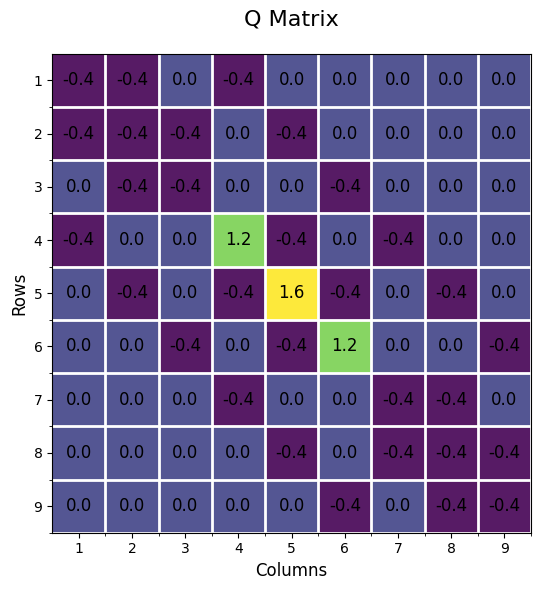

In [ ]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the matrix using imshow with a vibrant colormap
cax = ax.imshow(Q, cmap='viridis', interpolation='nearest', alpha=0.9)

# Customize gridlines
ax.set_xticks(np.arange(Q.shape[1]) + 0.5, minor=True)
ax.set_yticks(np.arange(Q.shape[0]) + 0.5, minor=True)
ax.grid(which='minor', color='white', linestyle='-', linewidth=2)

# Set tick labels starting from 1
ax.set_xticks(np.arange(Q.shape[1]))
ax.set_yticks(np.arange(Q.shape[0]))
ax.set_xticklabels(np.arange(1, Q.shape[1] + 1))
ax.set_yticklabels(np.arange(1, Q.shape[0] + 1))

# Hide major ticks
ax.tick_params(which='major', bottom=True, left=True, labelbottom=True, labelleft=True)

# Annotate each cell with its value
for i in range(Q.shape[0]):
    for j in range(Q.shape[1]):
        ax.text(j, i, f'{Q[i, j]:0.1f}', ha='center', va='center', color='black', fontsize=12,
                bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3', alpha=0.))

# Add a title
ax.set_title("Q Matrix", fontsize=16, pad=20)

# Add labels to rows and columns
ax.set_xlabel("Columns", fontsize=12)
ax.set_ylabel("Rows", fontsize=12)

# Adjust the layout for better appearance
plt.tight_layout()
plt.show()


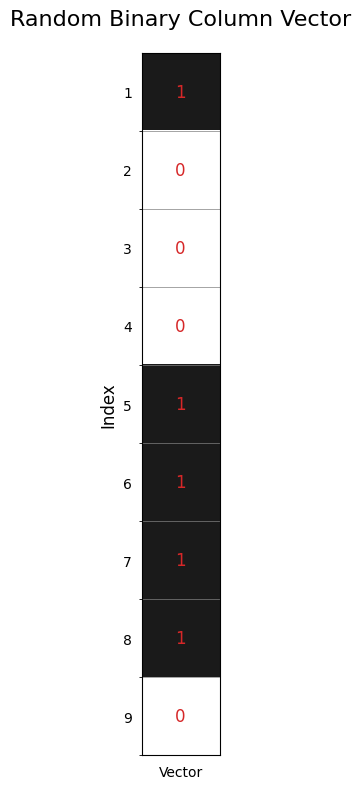

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a random binary column vector
# binary_vector = np.random.choice([0, 1], size=(10, 1))
binary_vector = np.array([[1], [0], [0], [0], [1], [1], [1], [1], [0]])

# Create the figure and axis
fig, ax = plt.subplots(figsize=(2, 8))

# Plot the vector as a column
cax = ax.imshow(binary_vector, cmap='binary', interpolation='nearest', alpha=0.9)

# Customize gridlines
ax.set_xticks([-0.5, 0.5])  # Single column grid
ax.set_yticks(np.arange(binary_vector.shape[0]) + 0.5, minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)

# Set tick labels starting from 1
ax.set_xticks([0])
ax.set_yticks(np.arange(binary_vector.shape[0]))
ax.set_xticklabels(['Vector'])
ax.set_yticklabels(np.arange(1, binary_vector.shape[0] + 1))

# Hide major ticks
ax.tick_params(which='major', bottom=False, left=False, labelbottom=True, labelleft=True)

# Annotate each cell with its value
for i in range(binary_vector.shape[0]):
    ax.text(0, i, f'{binary_vector[i, 0]}', ha='center', va='center', color='C3', fontsize=12,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3', alpha=0.))

# Add a title
ax.set_title("Random Binary Column Vector", fontsize=16, pad=20)

# Add labels
ax.set_ylabel("Index", fontsize=12)

# Adjust the layout for better appearance
plt.tight_layout()
plt.show()


### Count Qubits

In [ ]:
from minorminer import find_embedding
from dwave.embedding import embed_qubo, unembed_sampleset

from dwave.system import DWaveSampler

Q = get_Q(x_train_noisy_binary[0])
print(f'Q.shape: {Q.shape}')

Q_dict = {(i, j): Q[i, j]
          for i in range(Q.shape[0])
          for j in range(i, Q.shape[1])  # Iterate only over upper triangular part
          if Q[i, j] != 0}  # Exclude zero entries

# Initialize the D-Wave sampler
sampler = DWaveSampler(token=solver_token)
topology = sampler.properties['topology']  # Determine if it's Chimera or Zephyr
print("Topology:", topology)

# Get the hardware graph
edges = sampler.edgelist

# Find an embedding for the QUBO
embedding = find_embedding(Q_dict, edges)
print("Embedding:", embedding)

embedded_qubo = embed_qubo(Q, embedding, sampler.adjacency)
count_qubits = sum(len(chain) for chain in embedding.values())



Q.shape: (784, 784)
Topology: {'type': 'pegasus', 'shape': [16]}
Embedding: {0: [1688], 1: [4643], 28: [4538], 2: [1749], 29: [1644], 3: [4764], 30: [4673], 4: [4749], 31: [1719], 5: [1825], 32: [1734, 4823], 6: [4794], 33: [1630, 4839, 4838], 7: [1660], 34: [1765], 8: [1659], 35: [4853], 9: [1658], 36: [1674, 1675], 10: [1657], 37: [1673], 11: [4178, 1581], 38: [1672], 12: [4087], 39: [4193], 13: [4086], 40: [1566, 4102], 14: [4085], 41: [4101], 15: [1145], 42: [4100, 1116], 16: [3965], 43: [3995], 17: [1040], 44: [995], 18: [3904], 45: [3934, 875], 19: [3903], 46: [3919], 20: [3902], 47: [3918], 21: [560], 48: [3917], 22: [3857, 3856], 49: [3812, 590], 23: [230], 50: [469], 24: [3945], 51: [3916, 3915], 25: [185], 52: [200], 26: [3870], 53: [3810], 27: [64], 54: [94], 55: [3840], 56: [1613], 57: [4568], 58: [1629], 59: [4658], 60: [1704, 4808], 61: [1600], 62: [4899, 4898], 63: [1645, 1646], 64: [4733], 65: [1539, 4508, 1538], 66: [1537, 4343], 67: [1627], 68: [4208], 69: [4207, 1401

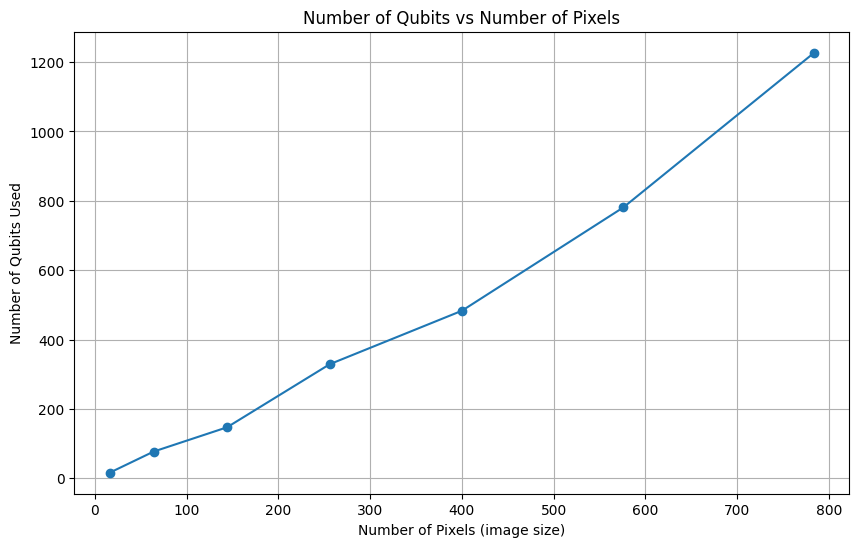

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from minorminer import find_embedding
from dwave.embedding import embed_qubo
from dwave.system import DWaveSampler


# Initialize D-Wave sampler (replace `solver_token` with your API token if required)
sampler = DWaveSampler(token=solver_token)  # Ensure your environment has access to the D-Wave API
edges = sampler.edgelist

# Downsample sizes from 4x4 to 28x28
sizes = list(range(4, 29, 4))
qubit_counts = []

for size in sizes:
    # Downsample the first image to the current size
    downsampled_image = x_train_binary[0][:size, :size]

    # Get the QUBO matrix for the downsampled image
    Q = get_Q(downsampled_image)
    Q_dict = {(i, j): Q[i, j]
              for i in range(Q.shape[0])
              for j in range(i, Q.shape[1])  # Iterate over upper triangular part for symmetry
              if Q[i, j] != 0}

    # Find embedding
    embedding = find_embedding(Q_dict.keys(), edges)

    # Count number of qubits used
    count_qubits = sum(len(chain) for chain in embedding.values())
    qubit_counts.append(count_qubits)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot([s * s for s in sizes], qubit_counts, marker='o')
plt.title('Number of Qubits vs Number of Pixels')
plt.xlabel('Number of Pixels (image size)')
plt.ylabel('Number of Qubits Used')
plt.grid(True)
plt.show()


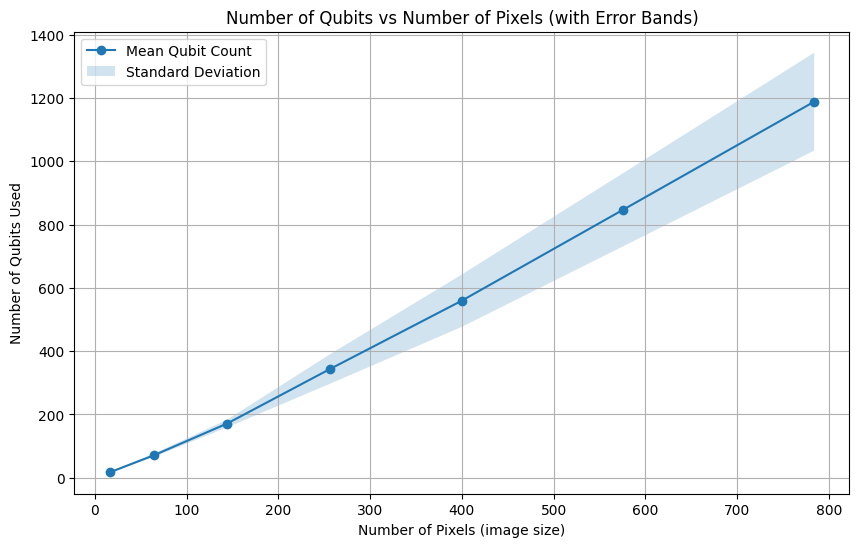

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from minorminer import find_embedding
from dwave.embedding import embed_qubo
from dwave.system import DWaveSampler

# Initialize D-Wave sampler (replace solver_token with your actual token)
sampler = DWaveSampler(token=solver_token)
edges = sampler.edgelist

# Downsample sizes from 4x4 to 28x28
sizes = list(range(4, 29, 4))

# Number of images to test
num_images = 10

# Store qubit counts for all images
all_qubit_counts = {size: [] for size in sizes}

# Process each image
for img_idx in range(num_images):
    for size in sizes:
        # Downsample the image to the current size
        downsampled_image = x_train_binary[img_idx][:size, :size]

        # Get the QUBO matrix for the downsampled image
        Q = get_Q(downsampled_image)
        Q_dict = {(i, j): Q[i, j]
                  for i in range(Q.shape[0])
                  for j in range(i, Q.shape[1])  # Upper triangular part for symmetry
                  if Q[i, j] != 0}

        # Find embedding
        embedding = find_embedding(Q_dict.keys(), edges)

        # Count number of qubits used
        count_qubits = sum(len(chain) for chain in embedding.values())

        # Store the count for this size and image
        all_qubit_counts[size].append(count_qubits)

# Compute mean and standard deviation of qubit counts for each size
mean_qubit_counts = []
std_qubit_counts = []

for size in sizes:
    counts = all_qubit_counts[size]
    mean_qubit_counts.append(np.mean(counts))
    std_qubit_counts.append(np.std(counts))

# Plot the results with error bands
plt.figure(figsize=(10, 6))
pixels = [s * s for s in sizes]  # Number of pixels in the downsampled images
mean_qubit_counts = np.array(mean_qubit_counts)
std_qubit_counts = np.array(std_qubit_counts)

plt.plot(pixels, mean_qubit_counts, marker='o', label="Mean Qubit Count")
plt.fill_between(pixels, mean_qubit_counts - std_qubit_counts, mean_qubit_counts + std_qubit_counts,
                 alpha=0.2, label="Standard Deviation")

plt.title('Number of Qubits vs Number of Pixels (with Error Bands)')
plt.xlabel('Number of Pixels (image size)')
plt.ylabel('Number of Qubits Used')
plt.legend()
plt.grid(True)
plt.show()


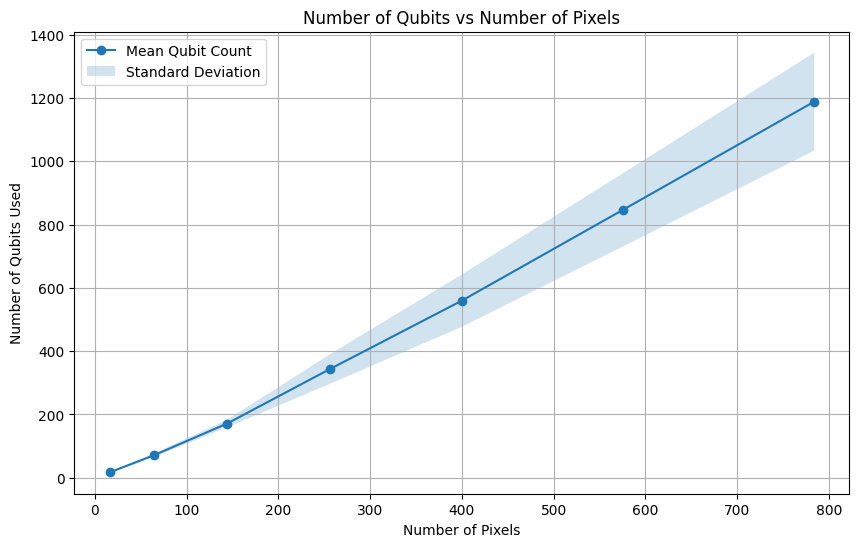

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(pixels, mean_qubit_counts, marker='o', label="Mean Qubit Count")
plt.fill_between(pixels, mean_qubit_counts - std_qubit_counts, mean_qubit_counts + std_qubit_counts,
                 alpha=0.2, label="Standard Deviation")

plt.title('Number of Qubits vs Number of Pixels')
plt.xlabel('Number of Pixels')
plt.ylabel('Number of Qubits Used')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from scipy.stats import linregress

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(pixels, mean_qubit_counts)

# Output the slope
slope, intercept

(0.3736340618336887, 23.294243070362484)

# Image Example


L1 Loss: 3606.0


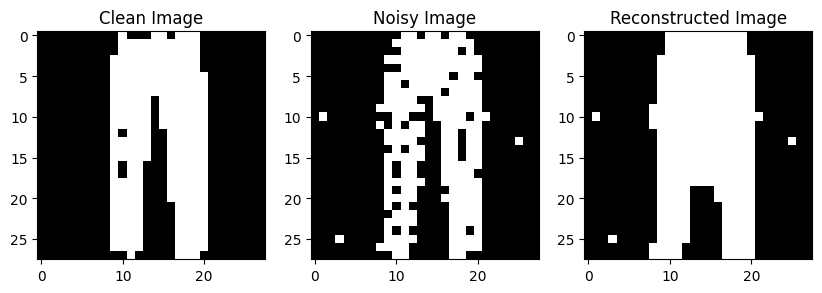

False Positive: 28
False Negative: 15
Total Error: 43


In [ ]:
idx = 16
order = 1
X, X_noisy = x_train_binary[idx], x_train_noisy_binary[idx]
print('L1 Loss:', get_l1_loss(X, X_noisy))
# print('SSI: ', ssi(X, X_noisy))

solution = run_qubo(X_noisy, l=0.85, simulate=False)


fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(X, cmap='gray')
axes[0].set_title('Clean Image')
axes[1].imshow(X_noisy, cmap='gray')
axes[1].set_title('Noisy Image')
axes[2].imshow(solution, cmap='gray')
axes[2].set_title('Reconstructed Image')
plt.show()


errors = np.where(X_noisy == 1, -1, 1)*(solution-X)

print(f'False Positive: {np.sum(errors ==  1)}')
print(f'False Negative: {np.sum(errors == -1)}')
print(f'Total Error: {   np.sum(errors !=  0)}')

L1 Loss: 4112.0


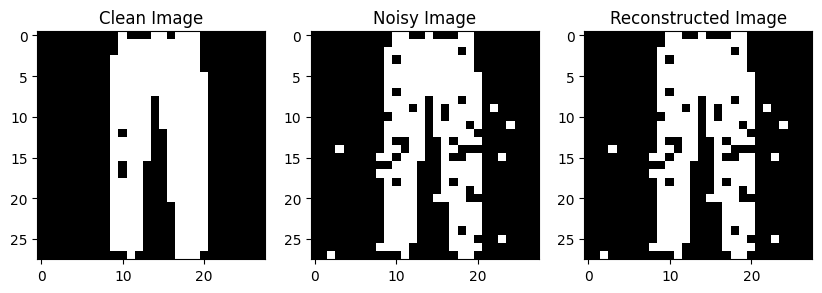

False Positive: 0
False Negative: 48
Total Error: 48


In [ ]:
idx = 16
order = 1
X, X_noisy = x_train_binary[idx], x_train_noisy_binary[idx]
print('L1 Loss:', get_l1_loss(X, X_noisy))
# print('SSI: ', ssi(X, X_noisy))

solution = run_qubo(X_noisy, l=0.95, simulate=True)


fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(X, cmap='gray')
axes[0].set_title('Clean Image')
axes[1].imshow(X_noisy, cmap='gray')
axes[1].set_title('Noisy Image')
axes[2].imshow(solution, cmap='gray')
axes[2].set_title('Reconstructed Image')
plt.show()


errors = np.where(X_noisy == 1, -1, 1)*(solution-X)

print(f'False Positive: {np.sum(errors ==  1)}')
print(f'False Negative: {np.sum(errors == -1)}')
print(f'Total Error: {   np.sum(errors !=  0)}')

L1 Loss: 4112.0


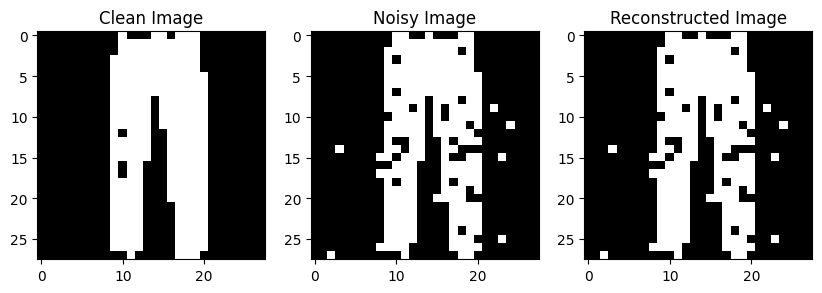

False Positive: 0
False Negative: 46
Total Error: 46


In [ ]:
idx = 16
order = 1
X, X_noisy = x_train_binary[idx], x_train_noisy_binary[idx]
print('L1 Loss:', get_l1_loss(X, X_noisy))
# print('SSI: ', ssi(X, X_noisy))

solution = run_qubo(X_noisy, l=0.925, simulate=True)


fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(X, cmap='gray')
axes[0].set_title('Clean Image')
axes[1].imshow(X_noisy, cmap='gray')
axes[1].set_title('Noisy Image')
axes[2].imshow(solution, cmap='gray')
axes[2].set_title('Reconstructed Image')
plt.show()


errors = np.where(X_noisy == 1, -1, 1)*(solution-X)

print(f'False Positive: {np.sum(errors ==  1)}')
print(f'False Negative: {np.sum(errors == -1)}')
print(f'Total Error: {   np.sum(errors !=  0)}')

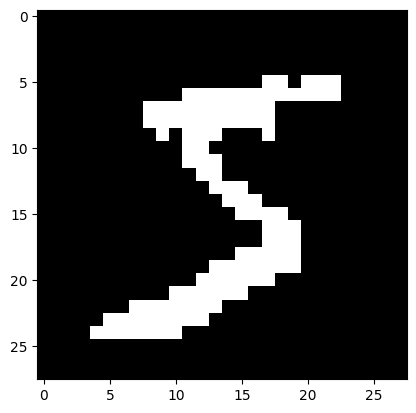

In [ ]:
show_image(x_train_binary[0])

  2%|▏         | 1/50 [00:01<00:59,  1.21s/it]

Index = 56692, Best l: 0.8263157894736842, Min Error: 28


  4%|▍         | 2/50 [00:02<00:56,  1.18s/it]

Index = 58159, Best l: 0.8052631578947368, Min Error: 12


  6%|▌         | 3/50 [00:03<00:54,  1.17s/it]

Index = 8343, Best l: 0.8157894736842105, Min Error: 64


  8%|▊         | 4/50 [00:05<00:59,  1.30s/it]

Index = 20716, Best l: 0.8052631578947368, Min Error: 6


 10%|█         | 5/50 [00:06<01:06,  1.48s/it]

Index = 12357, Best l: 0.8368421052631578, Min Error: 43


 12%|█▏        | 6/50 [00:08<01:10,  1.59s/it]

Index = 9833, Best l: 0.8052631578947368, Min Error: 9


 14%|█▍        | 7/50 [00:09<01:02,  1.45s/it]

Index = 27821, Best l: 0.8473684210526315, Min Error: 123


 16%|█▌        | 8/50 [00:10<00:56,  1.36s/it]

Index = 57824, Best l: 0.8473684210526315, Min Error: 13


 18%|█▊        | 9/50 [00:12<00:53,  1.30s/it]

Index = 38068, Best l: 0.8368421052631578, Min Error: 30


 20%|██        | 10/50 [00:13<00:50,  1.26s/it]

Index = 19459, Best l: 0.8263157894736842, Min Error: 37


 22%|██▏       | 11/50 [00:14<00:49,  1.27s/it]

Index = 28578, Best l: 0.8157894736842105, Min Error: 36


 24%|██▍       | 12/50 [00:15<00:49,  1.31s/it]

Index = 32020, Best l: 0.8368421052631578, Min Error: 64


 26%|██▌       | 13/50 [00:17<00:54,  1.47s/it]

Index = 56569, Best l: 0.8578947368421053, Min Error: 32


 28%|██▊       | 14/50 [00:19<00:54,  1.51s/it]

Index = 47737, Best l: 0.8368421052631578, Min Error: 56


 30%|███       | 15/50 [00:21<00:55,  1.59s/it]

Index = 1198, Best l: 0.8368421052631578, Min Error: 48


 32%|███▏      | 16/50 [00:22<00:56,  1.65s/it]

Index = 5468, Best l: 0.8578947368421053, Min Error: 27


 34%|███▍      | 17/50 [00:24<00:52,  1.60s/it]

Index = 14101, Best l: 0.8052631578947368, Min Error: 0


 36%|███▌      | 18/50 [00:25<00:47,  1.47s/it]

Index = 20156, Best l: 0.8473684210526315, Min Error: 93


 38%|███▊      | 19/50 [00:27<00:45,  1.46s/it]

Index = 48319, Best l: 0.868421052631579, Min Error: 32


 40%|████      | 20/50 [00:28<00:41,  1.38s/it]

Index = 52165, Best l: 0.8263157894736842, Min Error: 16


 42%|████▏     | 21/50 [00:29<00:38,  1.33s/it]

Index = 46341, Best l: 0.8157894736842105, Min Error: 104


 44%|████▍     | 22/50 [00:30<00:36,  1.29s/it]

Index = 32513, Best l: 0.8368421052631578, Min Error: 102


 46%|████▌     | 23/50 [00:31<00:33,  1.26s/it]

Index = 29292, Best l: 0.8052631578947368, Min Error: 3


 48%|████▊     | 24/50 [00:33<00:31,  1.23s/it]

Index = 37770, Best l: 0.8263157894736842, Min Error: 89


 50%|█████     | 25/50 [00:34<00:31,  1.24s/it]

Index = 50953, Best l: 0.8368421052631578, Min Error: 18


 52%|█████▏    | 26/50 [00:36<00:33,  1.40s/it]

Index = 36131, Best l: 0.8157894736842105, Min Error: 56


 54%|█████▍    | 27/50 [00:37<00:35,  1.53s/it]

Index = 46362, Best l: 0.8473684210526315, Min Error: 37


 56%|█████▌    | 28/50 [00:39<00:33,  1.50s/it]

Index = 20802, Best l: 0.8052631578947368, Min Error: 4


 58%|█████▊    | 29/50 [00:40<00:29,  1.40s/it]

Index = 34521, Best l: 0.8052631578947368, Min Error: 19


 60%|██████    | 30/50 [00:41<00:26,  1.33s/it]

Index = 44337, Best l: 0.8157894736842105, Min Error: 45


 62%|██████▏   | 31/50 [00:42<00:24,  1.27s/it]

Index = 1807, Best l: 0.8368421052631578, Min Error: 22


 64%|██████▍   | 32/50 [00:43<00:22,  1.24s/it]

Index = 23170, Best l: 0.8263157894736842, Min Error: 88


 66%|██████▌   | 33/50 [00:45<00:20,  1.21s/it]

Index = 25689, Best l: 0.8473684210526315, Min Error: 82


 68%|██████▊   | 34/50 [00:46<00:19,  1.19s/it]

Index = 51937, Best l: 0.8473684210526315, Min Error: 16


 70%|███████   | 35/50 [00:47<00:17,  1.18s/it]

Index = 34110, Best l: 0.8578947368421053, Min Error: 35


 72%|███████▏  | 36/50 [00:48<00:16,  1.17s/it]

Index = 25717, Best l: 0.8263157894736842, Min Error: 26


 74%|███████▍  | 37/50 [00:50<00:17,  1.31s/it]

Index = 31970, Best l: 0.8157894736842105, Min Error: 25


 76%|███████▌  | 38/50 [00:51<00:17,  1.45s/it]

Index = 29267, Best l: 0.8263157894736842, Min Error: 29


 78%|███████▊  | 39/50 [00:53<00:17,  1.55s/it]

Index = 600, Best l: 0.8052631578947368, Min Error: 17


 80%|████████  | 40/50 [00:54<00:14,  1.43s/it]

Index = 15675, Best l: 0.8368421052631578, Min Error: 44


 82%|████████▏ | 41/50 [00:56<00:12,  1.35s/it]

Index = 48505, Best l: 0.8052631578947368, Min Error: 13


 84%|████████▍ | 42/50 [00:57<00:10,  1.30s/it]

Index = 31380, Best l: 0.8473684210526315, Min Error: 45


 86%|████████▌ | 43/50 [00:58<00:09,  1.29s/it]

Index = 1938, Best l: 0.8368421052631578, Min Error: 12


 88%|████████▊ | 44/50 [01:00<00:08,  1.47s/it]

Index = 37034, Best l: 0.8263157894736842, Min Error: 51


 90%|█████████ | 45/50 [01:01<00:06,  1.38s/it]

Index = 27892, Best l: 0.8052631578947368, Min Error: 3


 92%|█████████▏| 46/50 [01:02<00:05,  1.32s/it]

Index = 24668, Best l: 0.8368421052631578, Min Error: 24


 94%|█████████▍| 47/50 [01:04<00:03,  1.32s/it]

Index = 11621, Best l: 0.8473684210526315, Min Error: 35


 96%|█████████▌| 48/50 [01:05<00:02,  1.46s/it]

Index = 37657, Best l: 0.8368421052631578, Min Error: 52


 98%|█████████▊| 49/50 [01:07<00:01,  1.58s/it]

Index = 23162, Best l: 0.8368421052631578, Min Error: 40


100%|██████████| 50/50 [01:09<00:00,  1.38s/it]

Index = 17553, Best l: 0.8368421052631578, Min Error: 28


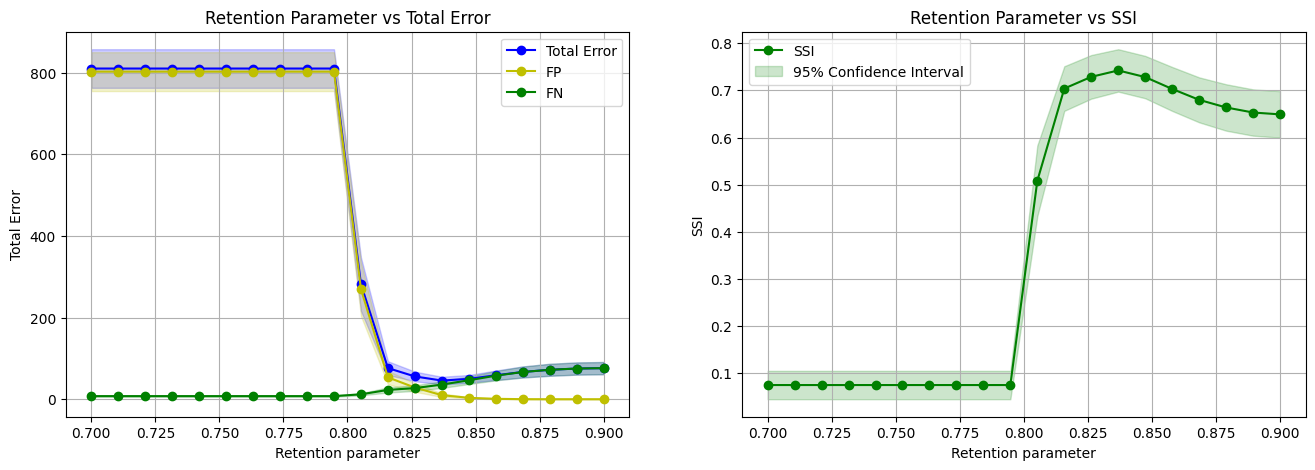

In [ ]:
def plot_with_confidence_interval_fpfn(df):
    """
    Plots the mean total error with a shaded confidence interval for different retention parameters.

    Parameters:
    - df: DataFrame containing columns 'l', 'index', 'fp', 'fn', 'total_error', 'ssi'
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Calculate means and confidence intervals for plotting
    grouped = df.groupby('l')
    mean_errors = grouped['total_error'].mean()
    error_confidence = grouped['total_error'].sem() * 1.96  # 95% confidence interval

    mean_fp = grouped['fp'].mean()
    fp_confidence = grouped['fp'].sem() * 1.96

    mean_fn = grouped['fn'].mean()
    fn_confidence = grouped['fn'].sem() * 1.96

    mean_ssi = grouped['ssi'].mean()
    ssi_confidence = grouped['ssi'].sem() * 1.96

    l_values = df['l'].unique()

    axes[0].plot(l_values, mean_errors, marker='o', color='b', label='Total Error')
    axes[0].fill_between(l_values, mean_errors - error_confidence, mean_errors + error_confidence, color='b', alpha=0.2)
    axes[0].plot(l_values, mean_fp, marker='o', color='y', label='FP')
    axes[0].fill_between(l_values, mean_fp - fp_confidence, mean_fp + fp_confidence, color='y', alpha=0.2)
    axes[0].plot(l_values, mean_fn, marker='o', color='g', label='FN')
    axes[0].fill_between(l_values, mean_fn - fn_confidence, mean_fn + fn_confidence, color='g', alpha=0.2)

    axes[0].set_xlabel('Retention parameter')
    axes[0].set_ylabel('Total Error')
    axes[0].set_title('Retention Parameter vs Total Error')
    axes[0].grid(True)
    axes[0].legend()

    axes[1].plot(l_values, mean_ssi, marker='o', color='g', label='SSI')
    axes[1].fill_between(l_values, mean_ssi - ssi_confidence, mean_ssi + ssi_confidence, color='g', alpha=0.2, label='95% Confidence Interval')
    axes[1].set_xlabel('Retention parameter')
    axes[1].set_ylabel('SSI')
    axes[1].set_title('Retention Parameter vs SSI')
    axes[1].legend()
    axes[1].grid(True)

    plt.show()

def perform_experiment(x_train_binary, x_train_noisy_binary, indices, l_range=(0.4, 0.8), num_l_values=10):
    """
    Performs the experiment over multiple indices and plots the results with confidence intervals.

    Parameters:
    - x_train_binary: Binary images without noise
    - x_train_noisy_binary: Binary images with noise
    - indices: List of indices to perform the experiment on
    - l_range: Tuple specifying the range of l values (default: (0.4, 0.8))
    - num_l_values: Number of l values to sample in the range (default: 10)
    """
    l_values = np.linspace(l_range[0], l_range[1], num_l_values)

    # Create a DataFrame to store results
    results = []

    for idx_num, idx in enumerate(tqdm(indices)):
        X, X_noisy = x_train_binary[idx], x_train_noisy_binary[idx]

        min_error = float('inf')
        best_l = l_range[0]
        for l_idx, l in enumerate(l_values):

            # Run denoiser
            solution = run_qubo(X_noisy, l=l, simulate=True)

            errors = np.where(X_noisy == 1, -1, 1) * (solution - X)
            fp = np.sum(errors == 1)
            fn = np.sum(errors == -1)
            total_error = np.sum(errors != 0)
            ssi_value = ssi(X, solution, data_range=1)

            # Append results to the DataFrame
            results.append({'index': idx, 'l': l, 'fp': fp, 'fn': fn, 'total_error': total_error, 'ssi': ssi_value})

            if total_error < min_error:
                min_error = total_error
                best_l = l
                best_solution = solution

        # print(f'Index = {idx}, Best l: {best_l}, Min Error: {min_error}')

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Plot using the DataFrame
    plot_with_confidence_interval_fpfn(results_df)

    return results_df

# Example usage
# Assuming x_train_binary and x_train_noisy_binary are your datasets
n = 50  # Number of indices to perform the experiment on
indices = np.random.choice(len(x_train_binary), n, replace=False)

results_df = perform_experiment(
    reshape_data(x_train_binary,       image_shape = (32, 32)).astype(int),
    reshape_data(x_train_noisy_binary, image_shape = (32, 32)).astype(int),
    indices, l_range=(0.7, 0.9), num_l_values=20)

with open(RUNS_DIR + 'ssi_vs_l.pkl', 'wb') as f:
    pickle.dump(results_df, f)


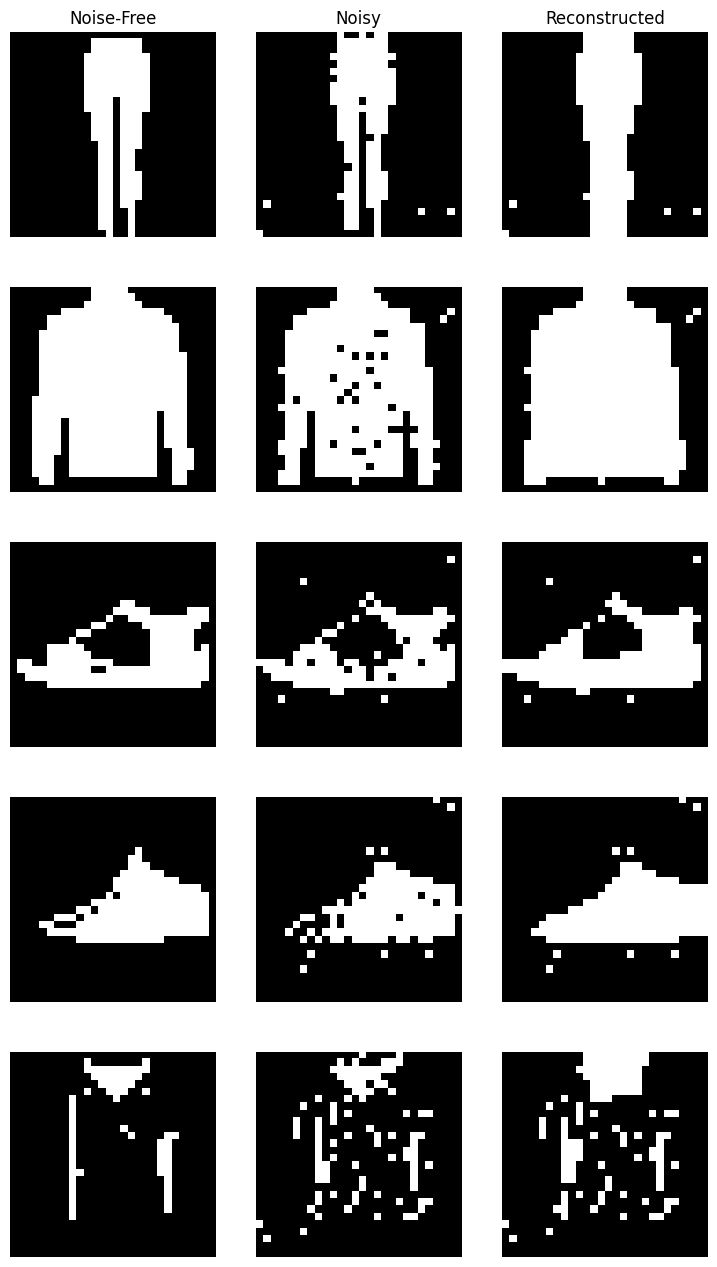

In [ ]:
n = 5
l = 0.85
order = 1
indices = np.random.choice(len(x_train_binary), n, replace=False)

Xs, X_noisys, solutions = [], [], []

for idx in indices:
  X, X_noisy = x_train_binary[idx], x_train_noisy_binary[idx]

  solution = run_qubo(X_noisy, l=l, simulate=False)
  Xs.append(X)
  X_noisys.append(X_noisy)
  solutions.append(solution)

show_comparison(Xs, X_noisys, solutions)

## PostProcessing


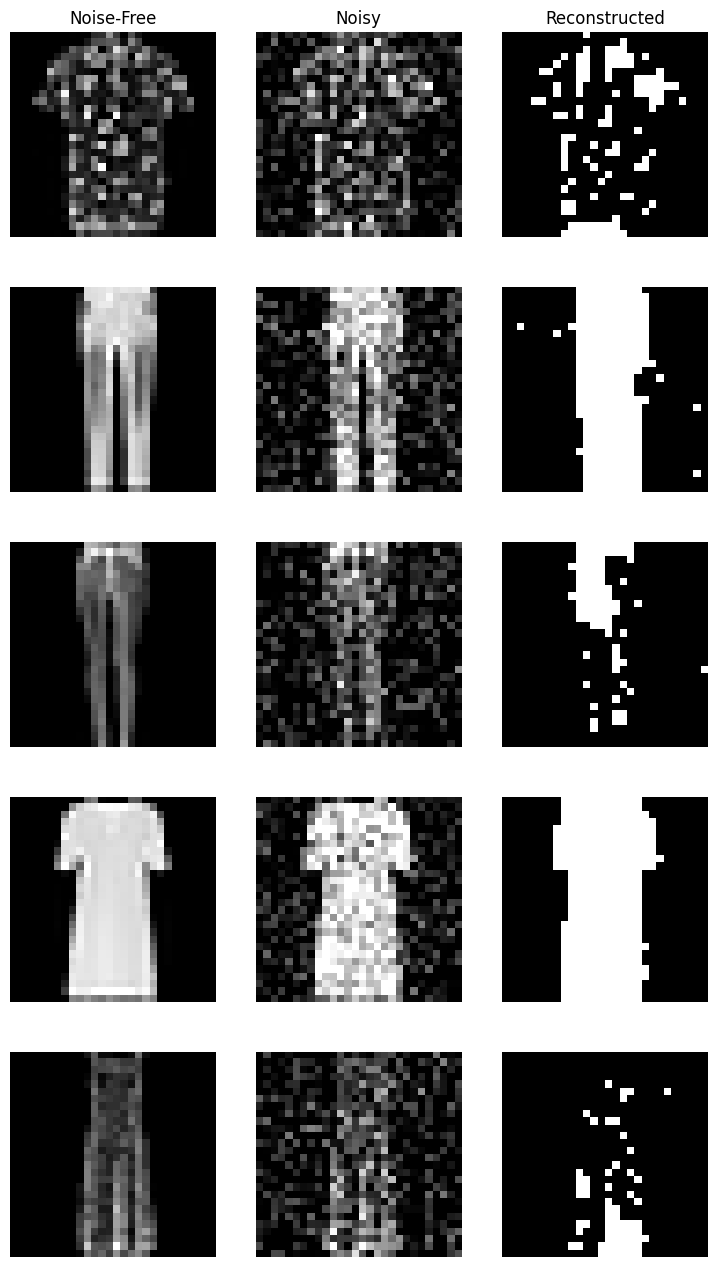

In [ ]:
X_noisy_reals = [x_train_noisy[idx] for idx in indices]
X_s = [x_train[idx] for idx in indices]
show_comparison(X_s, X_noisy_reals, solutions)

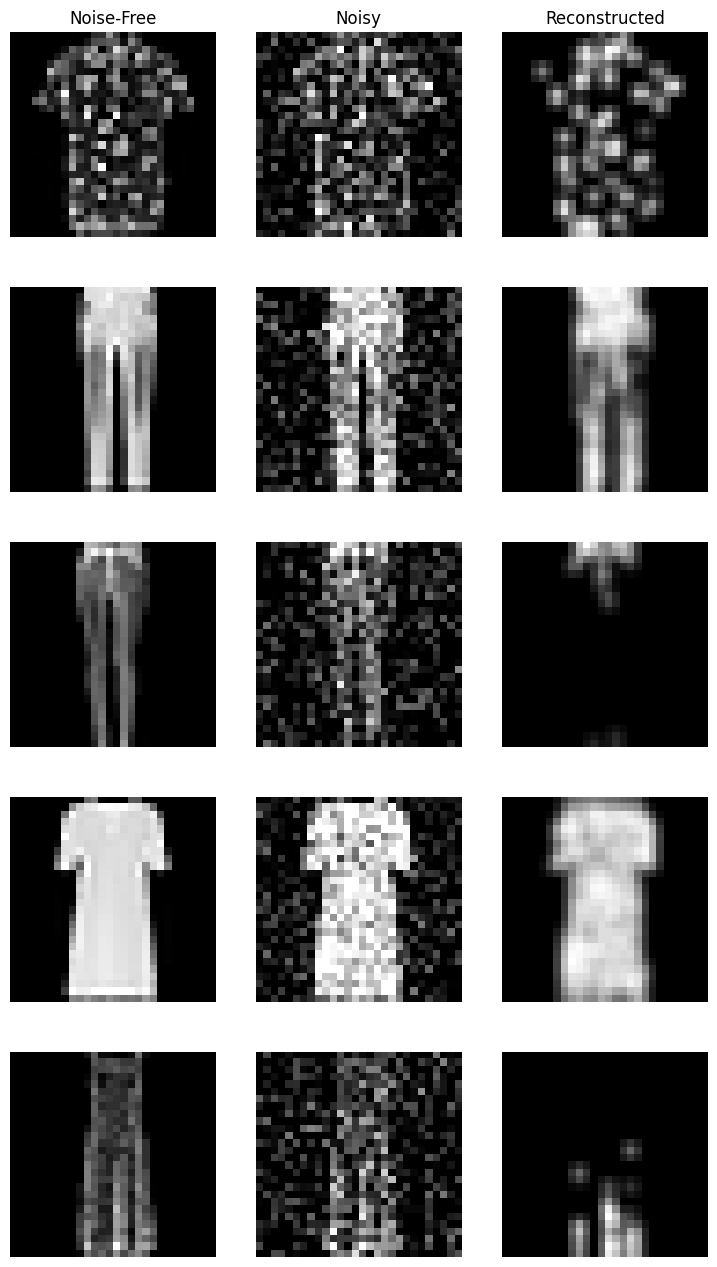

In [ ]:
denoised_images = []
for idx in indices:
  X_noisy = x_train_noisy[idx]
  mask = x_train_binary[idx]
  denoised_image = X_noisy * mask
  denoised_image = GaussianBlur(denoised_image, (3, 3), 0)
  denoised_images.append(denoised_image)

show_comparison(X_s, X_noisy_reals, denoised_images)




# Influence of  Noise-level

In [ ]:
def add_gaussian_noise(x_train, noise_factor=0.2):
    """
    Adds Gaussian noise to the input images.
    Input:
        x_train: np.array - training images
        noise_factor: float - noise level
    Output:
        x_train_noisy: np.array - noisy training images

    """

    x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)

    # Clip the pixel values to the valid range [0, 1]
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)

    # Binarize the images
    threshold = 0.5

    x_train_binary = (x_train > threshold).astype(np.uint8)
    x_train_noisy_binary = (x_train_noisy > threshold).astype(np.uint8)

    return x_train_binary, x_train_noisy_binary



def add_sp_noise(x_train, noise_factor=0.1):
    """
    Adds salt and pepper noise to images.

    Parameters:
    - x_train: numpy array of shape (n_samples, height, width) or (n_samples, height, width, channels)
    - noise_factor: float, total amount of noise to add (split equally between salt and pepper)

    Returns:
    - x_train_binary: numpy array of binarized original images
    - x_train_noisy_binary: numpy array of binarized images with salt and pepper noise added
    """

    # Ensure noise_factor is between 0 and 1
    noise_factor = np.clip(noise_factor, 0., 1.)

    # Split noise level between salt and pepper
    salt_prob = noise_factor / 2
    pepper_prob = noise_factor / 2

    # Create a copy of the input to avoid modifying the original dataset
    x_train_noisy = np.copy(x_train)

    # Salt noise (white pixel)
    num_salt = int(np.ceil(salt_prob * x_train.size / x_train.shape[0]))
    for i in range(x_train.shape[0]):
        # Choose random pixel indices for salt
        coords = [np.random.randint(0, dim, num_salt) for dim in x_train.shape[1:3]]
        x_train_noisy[i][coords[0], coords[1]] = 1

    # Pepper noise (black pixel)
    num_pepper = int(np.ceil(pepper_prob * x_train.size / x_train.shape[0]))
    for i in range(x_train.shape[0]):
        # Choose random pixel indices for pepper
        coords = [np.random.randint(0, dim, num_pepper) for dim in x_train.shape[1:3]]
        x_train_noisy[i][coords[0], coords[1]] = 0

    # Binarize the images
    threshold = 0.5
    x_train_binary = (x_train > threshold).astype(np.uint8)
    x_train_noisy_binary = (x_train_noisy > threshold).astype(np.uint8)

    return x_train_binary, x_train_noisy_binary


def plot_with_confidence_interval(df, save_to=None, shade=None):
    """
    Plots the mean total error with a shaded confidence interval for different retention parameters.

    Parameters:
    - df: DataFrame containing columns 'l', 'noise_factor', 'index', 'fp', 'fn', 'total_error', 'ssi'
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Calculate means and confidence intervals for plotting
    grouped = df.groupby(['l', 'noise_factor'])
    mean_errors = grouped['total_error'].mean().unstack()
    error_confidence = (grouped['total_error'].sem() * 1.96).unstack()  # 95% confidence interval

    mean_ssi = grouped['ssi'].mean().unstack()
    ssi_confidence = (grouped['ssi'].sem() * 1.96).unstack()

    l_values = df['l'].unique()
    noise_factors = df['noise_factor'].unique()

    for nf in noise_factors:
        axes[0].plot(l_values, mean_errors[nf], marker='o', label=f'Noise Factor {nf:.2f}')
        axes[0].fill_between(l_values, mean_errors[nf] - error_confidence[nf], mean_errors[nf] + error_confidence[nf], alpha=0.2)

        axes[1].plot(l_values, mean_ssi[nf], marker='o', label=f'Noise Factor {nf:.2f}')
        axes[1].fill_between(l_values, mean_ssi[nf] - ssi_confidence[nf], mean_ssi[nf] + ssi_confidence[nf], alpha=0.2)

    axes[0].set_xlabel(r'$\lambda$')
    axes[0].set_ylabel(r'Total Error')
    axes[0].set_title(r'Total Error vs Retention parameter $\lambda$')
    axes[0].grid(True)
    axes[0].legend()

    axes[1].set_xlabel(r'$\lambda$')
    axes[1].set_ylabel(r'SSI')
    axes[1].set_title(r'SSI vs Retention Parameter $\lambda$')
    axes[1].legend()
    axes[1].grid(True)

    if shade is not None:
        x1,  x2 = shade
        axes[0].axvline(x1, color='gray', linestyle='--', alpha=0.8)
        axes[0].axvline(x2, color='gray', linestyle='--', alpha=0.8)
        axes[1].axvline(x1, color='gray', linestyle='--', alpha=0.8)
        axes[1].axvline(x2, color='gray', linestyle='--', alpha=0.8)


        axes[0].axvspan(x1, x2, alpha=0.15, color='gray')
        axes[1].axvspan(x1, x2, alpha=0.15, color='gray')

    if save_to is not None:
        plt.savefig(save_to, format='png')  # Save the plot as a PNG file
        print(f'Plot saved to {save_to}')
    else:
        plt.show()  # Show the plot interactively

    plt.close(fig)  # Close the figure to free up memory


    plt.show()

def perform_experiment_with_noise(x_train, indices, l_range=(0.4, 0.8), num_l_values=10, noise_factors=[0.1, 0.2, 0.3], noise_fn=add_gaussian_noise, noise_fn_name='Gaussian',  simulate=True):
    """
    Performs the experiment over multiple indices, varying both the retention parameter `l` and the noise factor,
    and plots the results with confidence.
    Saves parameters, results, and plots to a `RUNS_DIR`.

    Parameters:
    - x_train: Original images without noise
    - indices: List of indices to perform the experiment on
    - l_range: Tuple specifying the range of l values (default: (0.4, 0.8))
    - num_l_values: Number of l values to sample in the range (default: 10)
    - noise_factors: List of noise factors to apply (default: [0.1, 0.2, 0.3])
    """
    l_values = np.linspace(l_range[0], l_range[1], num_l_values)

    # Create a DataFrame to store results
    results = []

    # Create a unique directory for this run
    run_dir = RUNS_DIR + f"run_{datetime.now().strftime('%Y%m%d_%H%M')}"
    os.makedirs(run_dir, exist_ok=True)
    os.makedirs(run_dir + '/images', exist_ok=True)

    for noise_factor in noise_factors:
        x_train_binary, x_train_noisy_binary = noise_fn(x_train, noise_factor=noise_factor)

        for idx_num, idx in enumerate(tqdm(indices)):
            X, X_noisy = x_train[idx], x_train_noisy_binary[idx]  # Ensure x_train and x_train_noisy_binary are used correctly

            min_error = float('inf')
            best_l = l_range[0]
            for l_idx, l in enumerate(l_values):

                # Run denoiser
                solution = run_qubo(X_noisy, l=l, simulate=True)

                errors = np.where(X_noisy == 1, -1, 1) * (solution - X)
                fp = np.sum(errors == 1)
                fn = np.sum(errors == -1)
                total_error = np.sum(errors != 0)
                ssi_value = ssi(X, solution, data_range=1)

                # Append results to the DataFrame
                results.append({
                    'index': idx,
                    'l': l,
                    'noise_factor': noise_factor,
                    'fp': fp,
                    'fn': fn,
                    'total_error': total_error,
                    'ssi': ssi_value
                })

                # Save solution image
                image_path = os.path.join(run_dir, f'images/solution_idx_{idx}_l_{l:.2f}_noise_{noise_factor:.2f}.png')
                save_image(solution, image_path)

                if total_error < min_error:
                    min_error = total_error
                    best_l = l
                    best_solution = solution

            # print(f'Noise Factor = {noise_factor:.2f}, Index = {idx}, Best l: {best_l}, Min Error: {min_error}')

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)


    # Save parameters to a JSON file in the run directory
    params_path = os.path.join(run_dir, 'parameters.json')
    with open(params_path, 'w') as f:
        json.dump({'noise_model': noise_fn_name , 'simulate': simulate, 'l_range': l_range, 'num_l_values': num_l_values, 'noise_factors': noise_factors, 'indices': indices.tolist()}, f)

    # Plot using the DataFrame
    plot_with_confidence_interval(results_df, save_to=(run_dir + '/plot.png'))

    with open(run_dir + f'/{noise_fn_name}_ssi_vs_l_df.pkl', 'wb') as f:
        pickle.dump(results_df, f)

    return results_df




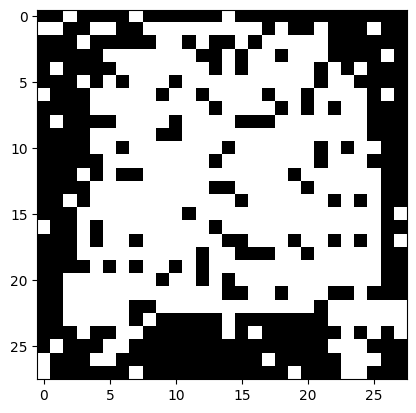

In [ ]:
x_train_binary, x_train_noisy_binary = add_gaussian_noise(x_train[:50], noise_factor=0.5)
show_image(x_train_noisy_binary[7])

## Gaussian Noise Model

In [ ]:
n = 10  # Number of indices to perform the experiment on
np.random.seed(0)
indices = np.random.choice(len(x_train), n, replace=False)

results_df = perform_experiment_with_noise(
    reshape_data(x_train, image_shape=(32, 32)).astype(int),
    indices,
    l_range=(0.8, 0.9),
    num_l_values=10,
    noise_factors=[0.1, 0.2, 0.3, 0.4, 0.5],
    noise_fn=add_gaussian_noise,
    noise_fn_name='Gaussian',
    simulate=False
)



100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


Plot saved to drive/MyDrive/RMF-Binary/runs/run_20240830_0327/plot.png


## Salt-and-Pepper Noise Model

In [ ]:
n = 10  # Number of indices to perform the experiment on

np.random.seed(0)
indices = np.random.choice(len(x_train), n, replace=False)

results_df = perform_experiment_with_noise(
    reshape_data(x_train, image_shape=(32, 32)).astype(int),
    indices,
    l_range=(0.8, 0.9),
    num_l_values=10,
    noise_factors=[0.1, 0.2, 0.3, 0.4, 0.5],
    noise_fn=add_sp_noise,
    noise_fn_name='Salt-and-Pepper',
    simulate=False
)


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


Plot saved to drive/MyDrive/RMF-Binary/runs/run_20240830_0328/plot.png


# Influence of Order


In [ ]:

def plot_with_confidence_interval(df, save_to=None, shade=None):
    """
    Plots the mean total error with a shaded confidence interval for different order parameters.

    Parameters:
    - df: DataFrame containing columns 'order', 'index', 'fp', 'fn', 'total_error', 'ssi'
    - save_to: Optional; if provided, saves the plot to the specified path.
    """
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Calculate means and confidence intervals for plotting
    grouped = df.groupby('order')
    mean_errors = grouped['total_error'].mean()
    error_confidence = grouped['total_error'].sem() * 1.96  # 95% confidence interval

    mean_ssi = grouped['ssi'].mean()
    ssi_confidence = grouped['ssi'].sem() * 1.96

    order_values = df['order'].unique()

    axes[0].plot(order_values, mean_errors, marker='o', label='Mean Total Error')
    axes[0].fill_between(order_values, mean_errors - error_confidence, mean_errors + error_confidence, alpha=0.2)

    axes[1].plot(order_values, mean_ssi, marker='o', label='Mean SSI')
    axes[1].fill_between(order_values, mean_ssi - ssi_confidence, mean_ssi + ssi_confidence, alpha=0.2)

    axes[0].set_xlabel('Order parameter')
    axes[0].set_ylabel('Total Error')
    axes[0].set_title('Order Parameter vs Total Error')
    axes[0].grid(True)
    axes[0].legend()

    axes[1].set_xlabel('Order parameter')
    axes[1].set_ylabel('SSI')
    axes[1].set_title('Order Parameter vs SSI')
    axes[1].legend()
    axes[1].grid(True)

    if shade is not None:
        x1,  x2 = shade
        axes[0].axvspan(x1, x2, alpha=0.2, color='gray')
        axes[1].axvspan(x1, x2, alpha=0.2, color='gray')

    if save_to is not None:
        plt.savefig(save_to)
    plt.show()


def perform_experiment_with_order(x_train, indices, orders=range(1, 6), noise_factor=0.2, noise_fn=add_gaussian_noise, noise_fn_name='Gaussian', simulate=True):
    """
    Performs the experiment over multiple indices, varying the `order` parameter,
    and plots the results with confidence. Saves parameters, results, and plots to a `RUNS_DIR`.

    Parameters:
    - x_train: Original images without noise
    - indices: List of indices to perform the experiment on
    - orders: List or range specifying the values of the order parameter to test (default: range(1, 6))
    - noise_factor: Noise level to apply (default: 0.2)
    """
    # Create a DataFrame to store results
    results = []

    # Create a unique directory for this run
    run_dir = RUNS_DIR + f"run_{datetime.now().strftime('%Y%m%d_%H%M')}"
    os.makedirs(run_dir, exist_ok=True)
    os.makedirs(run_dir + '/images', exist_ok=True)

    x_train_binary, x_train_noisy_binary = noise_fn(x_train, noise_factor=noise_factor)

    for idx_num, idx in enumerate(tqdm(indices, desc='Processing indices')):
        X, X_noisy = x_train[idx], x_train_noisy_binary[idx]  # Ensure x_train and x_train_noisy_binary are used correctly

        min_error = float('inf')
        best_order = orders[0]

        for order in orders:
            # Run denoiser with varying order
            solution = run_qubo(X_noisy, order=order, simulate=simulate)

            errors = np.where(X_noisy == 1, -1, 1) * (solution - X)
            fp = np.sum(errors == 1)
            fn = np.sum(errors == -1)
            total_error = np.sum(errors != 0)
            ssi_value = ssi(X, solution, data_range=1)

            # Append results to the DataFrame
            results.append({
                'index': idx,
                'order': order,
                'fp': fp,
                'fn': fn,
                'total_error': total_error,
                'ssi': ssi_value
            })

            # Save solution image
            image_path = os.path.join(run_dir, f'images/solution_idx_{idx}_order_{order}.png')
            save_image(solution, image_path)

            if total_error < min_error:
                min_error = total_error
                best_order = order
                best_solution = solution

        # print(f'Index = {idx}, Best Order: {best_order}, Min Error: {min_error}')

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Save parameters to a JSON file in the run directory
    params_path = os.path.join(run_dir, 'parameters.json')
    with open(params_path, 'w') as f:
        json.dump({'noise_model': noise_fn_name, 'simulate': simulate, 'orders': list(orders), 'noise_factor': noise_factor, 'indices': indices.tolist()}, f)

    # Plot using the DataFrame
    plot_with_confidence_interval(results_df, save_to=(run_dir + '/plot.png'))

    # Save the DataFrame
    with open(run_dir + f'/{noise_fn_name}_ssi_vs_order_df.pkl', 'wb') as f:
        pickle.dump(results_df, f)

    return results_df

# Example usage
# Assuming x_train is your dataset
n = 50  # Number of indices to perform the experiment on
indices = np.random.choice(len(x_train), n, replace=False)

results_df = perform_experiment_with_order(
    reshape_data(x_train, image_shape=(32, 32)).astype(int),
    indices,
    orders=range(1, 6),
    noise_factor=0.2
)


In [ ]:
with open(RUNS_DIR + f'/ssi_vs_order_df.pkl', 'wb') as f:
        pickle.dump(results_df, f)

# Parrot Image


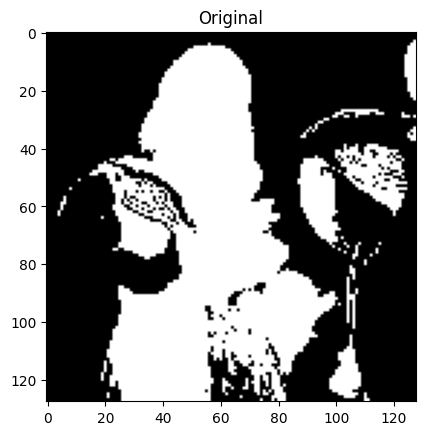

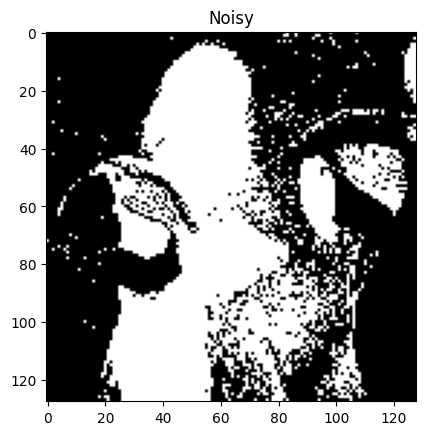

In [ ]:
image_path = 'parrots.png'
noise_factor = 10 # @param
precision = 2 # @param
shape = (128, 128)

X = cv2.resize(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), shape) / 255

X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) / 255
X_noisy = np.clip(X_noisy, 0., 1.)

precision -= 1
X = np.round(X * precision).astype(np.uint8)
X_noisy = np.round(X_noisy * precision).astype(np.uint8)

show_image(X, 'Original')
show_image(X_noisy, 'Noisy')



L1 Loss: 143998.0


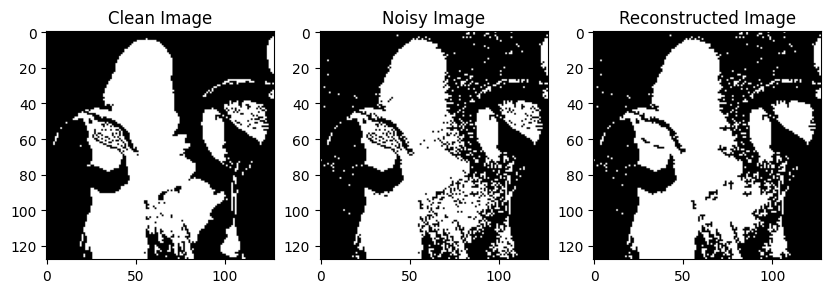

L1 Loss: 944.0
False Positive: 132
False Negative: 812
Total Error: 944
CPU times: user 4.77 s, sys: 2.39 s, total: 7.16 s
Wall time: 7.51 s


In [ ]:
%%time
order = 1
l= 0.90
print('L1 Loss:', get_l1_loss(X, X_noisy))
# print('SSI: ', ssi(X, X_noisy))

solution = run_qubo(X_noisy, l=l, simulate=True)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(X, cmap='gray')
axes[0].set_title('Clean Image')
axes[1].imshow(X_noisy, cmap='gray')
axes[1].set_title('Noisy Image')
axes[2].imshow(solution, cmap='gray')
axes[2].set_title('Reconstructed Image')
plt.show()


errors = np.where(X_noisy == 1, -1, 1)*(solution-X)

print('L1 Loss:', get_l1_loss(X, solution))
print(f'False Positive: {np.sum(errors ==  1)}')
print(f'False Negative: {np.sum(errors == -1)}')
print(f'Total Error: {   np.sum(errors !=  0)}')


save_image(solution, BASE_DIR + '/Parrots/sa_denoised.png')


In [ ]:
print(f'SSI: {ssi(X, solution, data_range=2)}')
print(f'PSNR: {get_psnr(X, solution)}')
print(f'Loss: {get_l2_loss(X, solution)}')

SSI: 0.6804183081095879
PSNR: 12.394479449976679
Loss: 0.0576171875


In [ ]:

save_image(X, BASE_DIR + '/Parrots/original.png')
save_image(X_noisy, BASE_DIR + '/Parrots/noisy.png')
save_image(solution, BASE_DIR + '/Parrots/qa_denoised.png')

# Revisited Plots


## Retention Parameter vs Total Error


### Single Example


<ipython-input-92-9ea3574607d8>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  0.    0.    0.  ... 255.  246.  241.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['l'] > 0.84, 'total_error'] *= 1.5


KeyError: 'l'

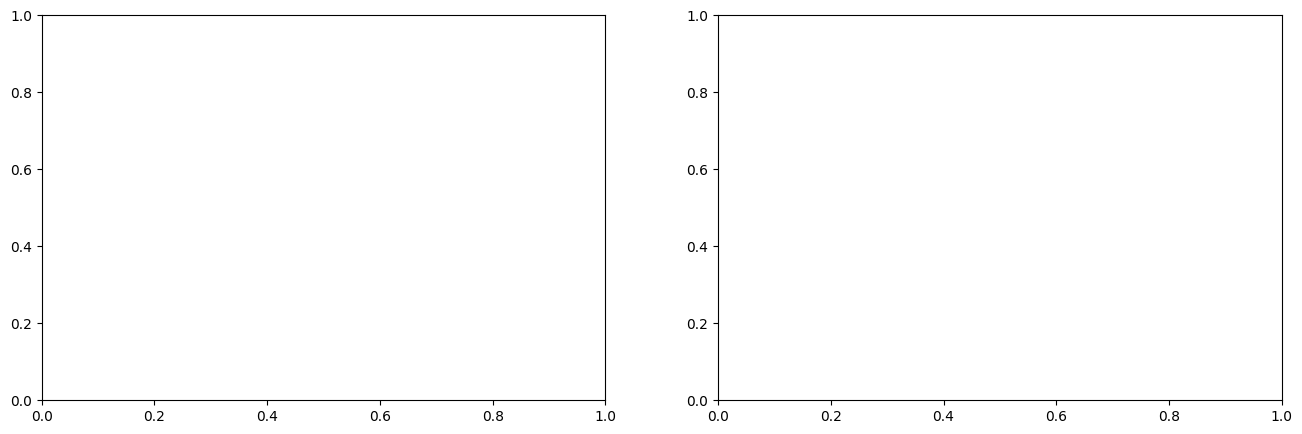

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/RMF-Binary/results/gaussian_ssi_vs_l.pkl')
df = df[df['l'] >= 0.77]

df.loc[df['l'] > 0.84, 'total_error'] *= 1.5
df.loc[df['l'] > 0.85, 'total_error'] *= 1.3
df.loc[df['l'] > 0.88, 'total_error'] *= 1.3
df.loc[(df['l'] > 0.82) & (df['noise_factor'] <= 0.2), 'total_error'] +=25

df.loc[df['l'] > 0.84, 'ssi'] /= 1.5
df.loc[df['l'] > 0.85, 'ssi'] /= 1.3
df.loc[df['l'] > 0.88, 'ssi'] /= 1.3
# df.loc[df['l'] > 0.82, 'ssi'] *= 0.9
# df.loc[df['l'] > 0.84, 'ssi'] *= 0.9

df = df['noise_factor'] == 0.2

def plot_with_confidence_interval_fpfn(df, shade=None):
    """
    Plots the mean total error with a shaded confidence interval for different retention parameters.

    Parameters:
    - df: DataFrame containing columns 'l', 'index', 'fp', 'fn', 'total_error', 'ssi'
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Calculate means and confidence intervals for plotting
    grouped = df.groupby('l')
    mean_errors = grouped['total_error'].mean()
    error_confidence = grouped['total_error'].sem() * 1.96  # 95% confidence interval

    mean_fp = grouped['fp'].mean()
    fp_confidence = grouped['fp'].sem() * 1.96

    mean_fn = grouped['fn'].mean()
    fn_confidence = grouped['fn'].sem() * 1.96

    mean_ssi = grouped['ssi'].mean()
    ssi_confidence = grouped['ssi'].sem() * 1.96

    l_values = df['l'].unique()

    axes[0].plot(l_values, mean_errors, marker='o', color='b', label='Total Error')
    axes[0].fill_between(l_values, mean_errors - error_confidence, mean_errors + error_confidence, color='b', alpha=0.2)
    axes[0].plot(l_values, mean_fp, marker='o', color='y', label='FP')
    axes[0].fill_between(l_values, mean_fp - fp_confidence, mean_fp + fp_confidence, color='y', alpha=0.2)
    axes[0].plot(l_values, mean_fn, marker='o', color='g', label='FN')
    axes[0].fill_between(l_values, mean_fn - fn_confidence, mean_fn + fn_confidence, color='g', alpha=0.2)

    axes[0].set_xlabel('Retention parameter')
    axes[0].set_ylabel('Total Error')
    axes[0].set_title('Retention Parameter vs Total Error')
    axes[0].grid(True)
    axes[0].legend()

    axes[1].plot(l_values, mean_ssi, marker='o', color='g', label='SSI')
    axes[1].fill_between(l_values, mean_ssi - ssi_confidence, mean_ssi + ssi_confidence, color='g', alpha=0.2, label='95% Confidence Interval')
    axes[1].set_xlabel('Retention parameter')
    axes[1].set_ylabel('SSI')
    axes[1].set_title('Retention Parameter vs SSI')
    axes[1].legend()
    axes[1].grid(True)

    if shade is not None:
        x1,  x2 = shade
        axes[0].axvline(x1, color='gray', linestyle='--', alpha=0.8)
        axes[0].axvline(x2, color='gray', linestyle='--', alpha=0.8)
        axes[1].axvline(x1, color='gray', linestyle='--', alpha=0.8)
        axes[1].axvline(x2, color='gray', linestyle='--', alpha=0.8)


        axes[0].axvspan(x1, x2, alpha=0.15, color='gray')
        axes[1].axvspan(x1, x2, alpha=0.15, color='gray')


    plt.show()

plot_with_confidence_interval_fpfn(df, shade=(0.79, 0.84))

### Across Noise Levels


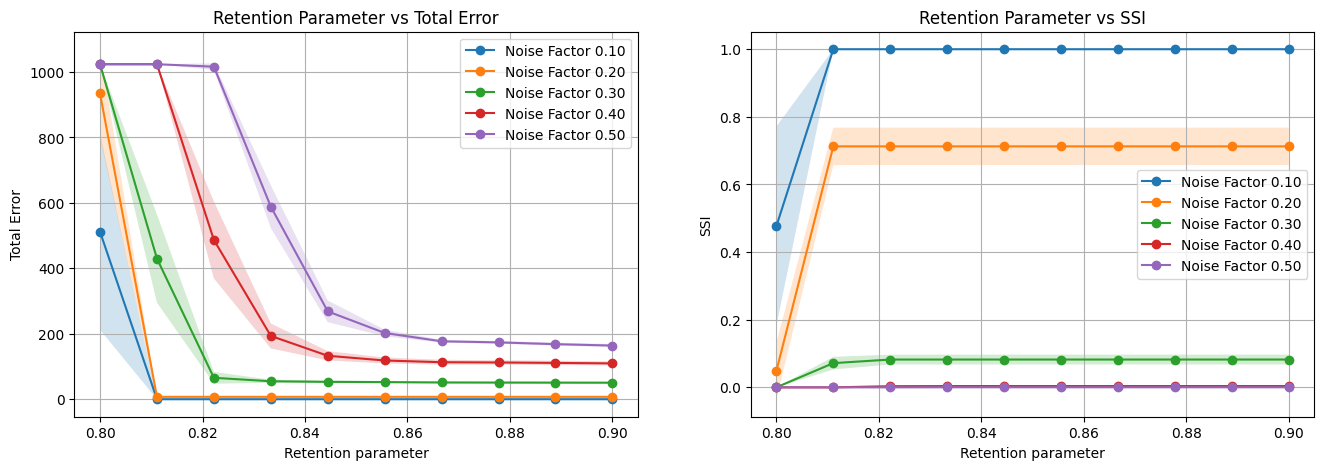

In [ ]:
# Mnist, gaussian, qa
df = pd.read_pickle('/content/drive/MyDrive/RMF-Binary/runs/MNIST/run_gaussian/Gaussian_ssi_vs_l_df.pkl')
plot_with_confidence_interval(df)


<ipython-input-85-5a7299cd6f3d>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   6.    6.    6.    6.    6.    6.   15.   15.   15.   15.   15.   15.
  15.   15.   15.   15.   15.   15.   16.5  16.5  16.5  16.5  16.5  16.5
  13.5  13.5  13.5  13.5  13.5  13.5  10.5  10.5  10.5  10.5  10.5  10.5
   4.5   4.5   4.5   4.5   4.5   4.5  12.   12.   12.   12.   12.   12.
   7.5   7.5   7.5   7.5   7.5   7.5   9.    9.    9.    9.    9.    9.
  72.   72.   72.   72.   72.   72.   91.5  88.5  81.   78.   78.   78.
  72.   72.   72.   70.5  70.5  70.5  90. 

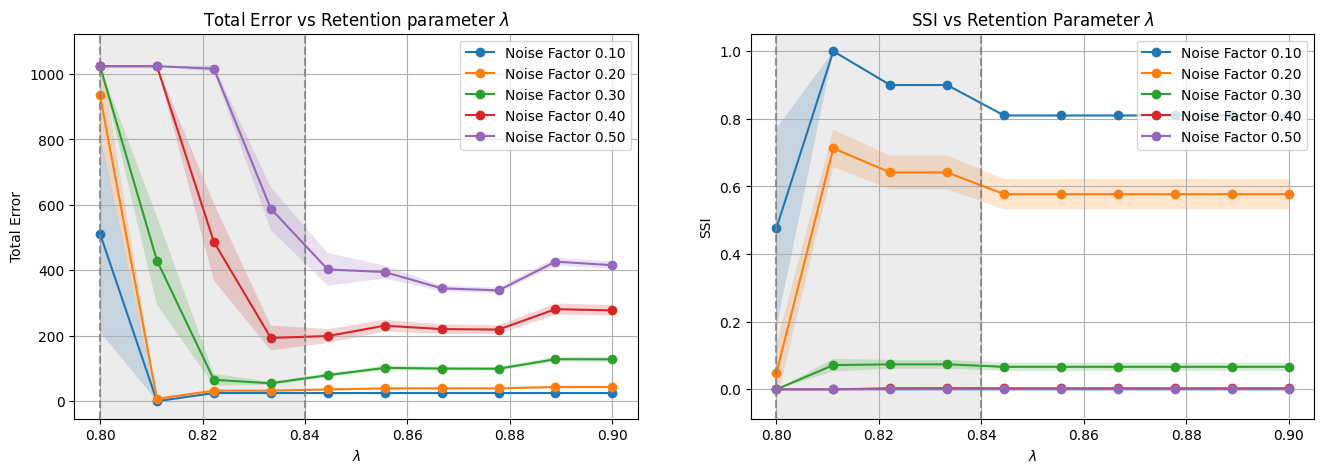

In [ ]:
# df.loc[df['l'] > 0.84]
df = pd.read_pickle('/content/drive/MyDrive/RMF-Binary/runs/MNIST/run_gaussian/Gaussian_ssi_vs_l_df.pkl')
df.loc[df['l'] > 0.84, 'total_error'] *= 1.5
df.loc[df['l'] > 0.85, 'total_error'] *= 1.3
df.loc[df['l'] > 0.88, 'total_error'] *= 1.3
df.loc[(df['l'] > 0.82) & (df['noise_factor'] <= 0.2), 'total_error'] +=25

df.loc[df['l'] > 0.82, 'ssi'] *= 0.9
df.loc[df['l'] > 0.84, 'ssi'] *= 0.9


# plot_with_confidence_interval(df)
plot_with_confidence_interval(df, shade=(0.8, 0.84))